# Análisis y Comparación de Modelos para Predicción de Productos Descontinuados

Este notebook explora y compara diferentes enfoques para predecir si un producto cosmético ha sido descontinuado, utilizando tanto modelos de grafos (GNN) como modelos clásicos de machine learning sobre datos tabulares.

## Estructura y objetivos principales:

- **Preparación de datos:**  
  Se cargan y normalizan los datos heterogéneos, construyendo un grafo donde los nodos representan productos, químicos, marcas, compañías y categorías, y las aristas representan relaciones entre ellos (por ejemplo, qué químicos contiene cada producto).

- **Modelos de grafos (GNN):**  
  Se implementan y entrenan varios escenarios de Graph Neural Networks:
  - **Escenario A:** GNN usando todas las relaciones y features
  - **Escenario B:** GNN sin las aristas con embeddings aprendibles, no utilizafeatures y aprende puramente de la topologia.
  
  Se evalúa el desempeño de cada escenario usando métricas como accuracy, F1-score y matriz de confusión, y se visualizan los embeddings de los productos antes y después del entrenamiento.

- **Modelos clásicos de machine learning:**  
  Se preparan datos tabulares agregando features por producto (como número de químicos, compañía, categoría, etc.) y se entrena un modelo Random Forest.  
  Se explora el impacto de incluir la identidad de los químicos mediante one-hot encoding y se analiza la importancia de cada feature, especialmente de los químicos, en la predicción.

- **Comparación y análisis:**  
  Se comparan los resultados de los modelos de grafos y los modelos clásicos, discutiendo en qué casos la información relacional del grafo aporta valor y cuándo los modelos tabulares son suficientes.


## Escenario A: Modelo con features para cada nodo.

In [50]:
import random
import numpy as np
import torch

seed = 11
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Cargar data ---
import numpy as np
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, HeteroConv, Linear
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Carga de datos
data = torch.load("hetero_data.pt", weights_only=False)

# --- Normaliza features de todos los nodos (excepto etiquetas) ---
for ntype in data.node_types:
    if hasattr(data[ntype], "x") and data[ntype].x is not None and data[ntype].x.shape[0] > 1:
        scaler = StandardScaler()
        x_np = data[ntype].x.cpu().numpy()
        data[ntype].x = torch.tensor(scaler.fit_transform(x_np), dtype=torch.float, device=data[ntype].x.device)

# --- Máscaras de train/test estratificadas ---
labels = data["Product"].y.cpu().numpy()
indices = np.arange(len(labels))
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42, stratify=labels)
train_mask = torch.zeros(len(labels), dtype=torch.bool)
test_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True
data["Product"].train_mask = train_mask
data["Product"].test_mask = test_mask

# --- Recalcula valid_edge_types ---
valid_edge_types = []
for (src, rel, dst), edge_index in data.edge_index_dict.items():
    if edge_index is not None and getattr(data[src], "x", None) is not None \
       and getattr(data[dst], "x", None) is not None and edge_index.shape[1] > 0:
        valid_edge_types.append((src, rel, dst))

# --- Agrega relaciones inversas ---
for (src, rel, dst) in valid_edge_types:
    if dst == "Product":
        continue
    edge_index = data[(src, rel, dst)].edge_index
    inv_rel = rel + "_rev"
    data[(dst, inv_rel, src)].edge_index = edge_index.flip(0)

# Vuelve a recalcular valid_edge_types con las nuevas relaciones
valid_edge_types = []
for (src, rel, dst), edge_index in data.edge_index_dict.items():
    if edge_index is not None and getattr(data[src], "x", None) is not None \
       and getattr(data[dst], "x", None) is not None and edge_index.shape[1] > 0:
        valid_edge_types.append((src, rel, dst))

# --- Calcula in_channels automáticamente ---
in_channels = {ntype: data[ntype].x.shape[1] for ntype in data.node_types if getattr(data[ntype], "x", None) is not None}

# --- Definición del modelo ---
num_classes = int(data["Product"].y.max().item() + 1)

class ProductGNN(torch.nn.Module):
    def __init__(self, hidden=128, dropout=0.0):
        super().__init__()
        conv1_dict = {(src, rel, dst): SAGEConv((in_channels[src], in_channels[dst]), hidden)
                      for (src, rel, dst) in valid_edge_types}
        self.conv1 = HeteroConv(conv1_dict, aggr='sum')

        conv2_dict = {edge_type: SAGEConv((hidden, hidden), hidden) for edge_type in conv1_dict}
        self.conv2 = HeteroConv(conv2_dict, aggr='sum')
        self.lin = Linear(hidden, num_classes)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x_dict, edge_index_dict):
        x = self.conv1(x_dict, edge_index_dict)
        x = {k: F.relu(self.dropout(v)) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)
        x = {k: self.dropout(v) for k, v in x.items()}
        out_dict = x.copy()
        out_dict["Product"] = self.lin(x["Product"])
        return out_dict
   
# --- Pesos de clase para CrossEntropyLoss ---
class_sample_count = np.bincount(labels)
weight = 1. / class_sample_count
weights = torch.tensor(weight, dtype=torch.float, device=data["Product"].y.device)

# --- Instancia del modelo, optimizador y función de pérdida ---
model = ProductGNN(hidden=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=weights)

model.eval()
with torch.no_grad():
    x = model.conv1(data.x_dict, data.edge_index_dict)
    x = {k: F.relu(v) for k, v in x.items()}
    x = model.conv2(x, data.edge_index_dict)
    prod_emb_pre = x["Product"].cpu().numpy()  



Epoch 01 | Loss: 1.1739 | Test Acc: 0.6496 | F1: 0.4119
Epoch 02 | Loss: 4.8790 | Test Acc: 0.1236 | F1: 0.1100
Epoch 03 | Loss: 2.7611 | Test Acc: 0.1687 | F1: 0.1638
Epoch 04 | Loss: 0.6316 | Test Acc: 0.7113 | F1: 0.6149
Epoch 05 | Loss: 1.4177 | Test Acc: 0.8682 | F1: 0.6457
Epoch 06 | Loss: 1.8601 | Test Acc: 0.8725 | F1: 0.6344
Epoch 07 | Loss: 1.4224 | Test Acc: 0.8677 | F1: 0.6454
Epoch 08 | Loss: 0.7613 | Test Acc: 0.8895 | F1: 0.7648
Epoch 09 | Loss: 0.5481 | Test Acc: 0.8388 | F1: 0.7280
Epoch 10 | Loss: 0.7750 | Test Acc: 0.6668 | F1: 0.5869
Epoch 11 | Loss: 0.9800 | Test Acc: 0.5640 | F1: 0.5107
Epoch 12 | Loss: 0.9697 | Test Acc: 0.5504 | F1: 0.5006
Epoch 13 | Loss: 0.7913 | Test Acc: 0.6256 | F1: 0.5566
Epoch 14 | Loss: 0.5749 | Test Acc: 0.7214 | F1: 0.6296
Epoch 15 | Loss: 0.4515 | Test Acc: 0.8552 | F1: 0.7485
Epoch 16 | Loss: 0.4655 | Test Acc: 0.8917 | F1: 0.7868
Epoch 17 | Loss: 0.5398 | Test Acc: 0.8907 | F1: 0.7737
Epoch 18 | Loss: 0.5997 | Test Acc: 0.8810 | F1:

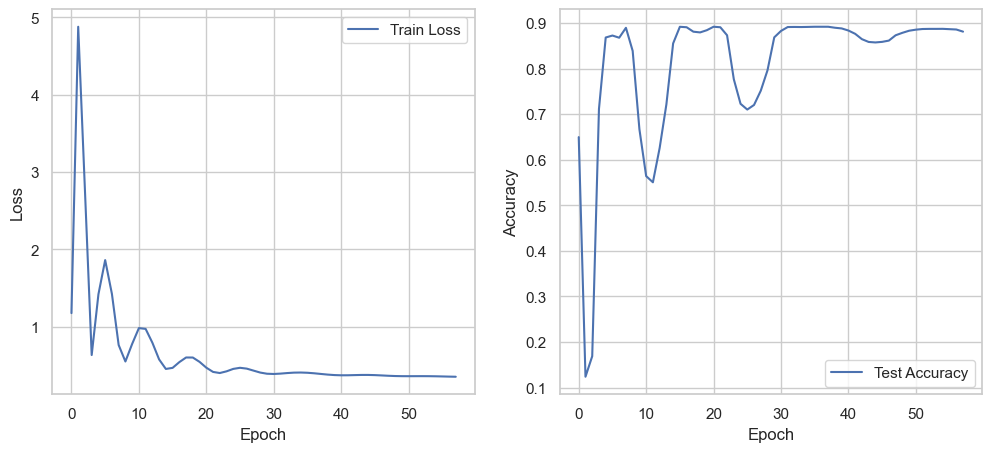

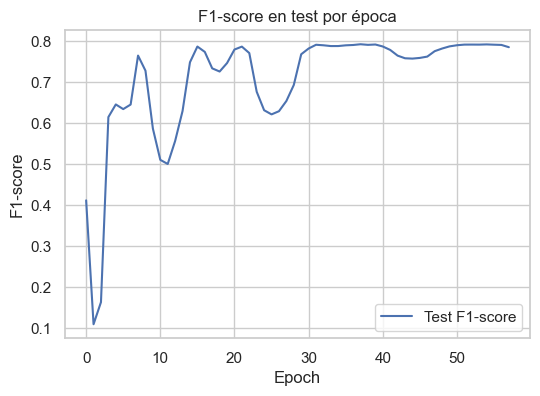

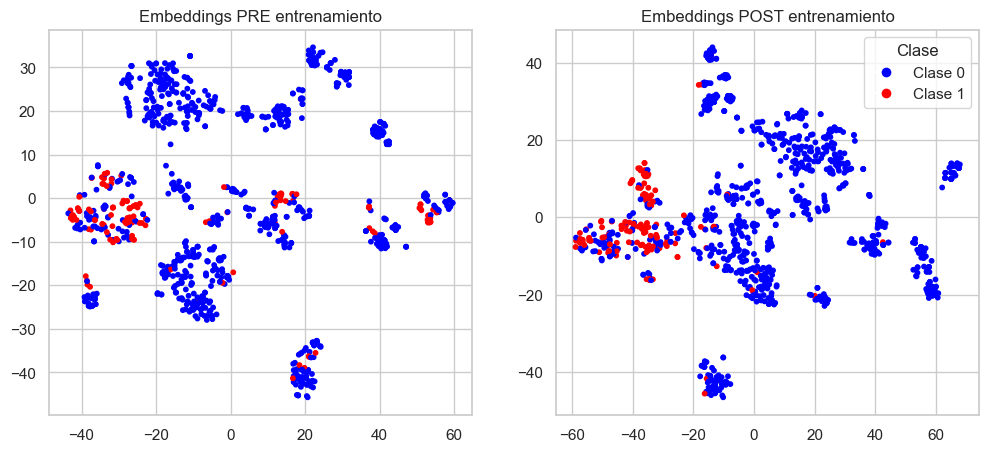

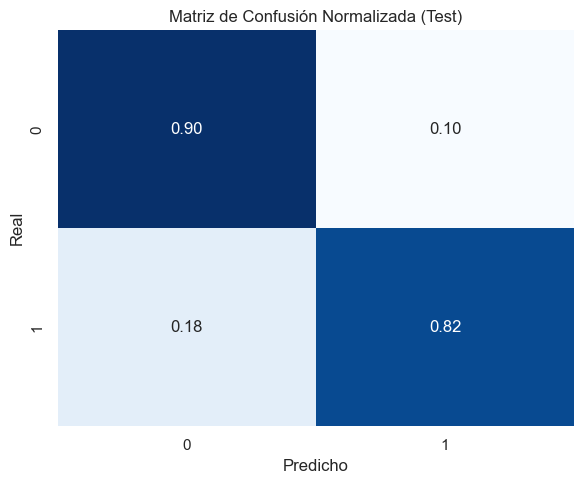

In [51]:
# --- Parámetros de early stopping ---
patience = 20                # épocas sin mejora antes de detener
best_f1 = 0.0
best_epoch = 0
no_improve = 0
best_model_path = 'best_model.pth'
best_prod_emb = None

# --- Entrenamiento con Early Stopping ---
train_losses, test_accs, test_f1s = [], [], []
for epoch in range(1, 61):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)['Product']
    loss = criterion(out[data["Product"].train_mask], data["Product"].y[data["Product"].train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        acc = (pred[data["Product"].test_mask] == data["Product"].y[data["Product"].test_mask]).float().mean()
        f1 = f1_score(data["Product"].y[data["Product"].test_mask].cpu().numpy(), 
                      pred[data["Product"].test_mask].cpu().numpy(), average='macro')

    train_losses.append(loss.item())
    test_accs.append(acc.item())
    test_f1s.append(f1)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Acc: {acc:.4f} | F1: {f1:.4f}")

    # Early Stopping Check
    if f1 > best_f1:
        best_f1 = f1
        best_epoch = epoch
        no_improve = 0
        # Guardar mejor modelo
        torch.save(model.state_dict(), best_model_path)
        # Calcular y guardar embeddings del mejor modelo
        emb_dict = model.conv1(data.x_dict, data.edge_index_dict)
        emb_dict = {k: F.relu(v) for k, v in emb_dict.items()}
        emb_dict = model.conv2(emb_dict, data.edge_index_dict)
        best_prod_emb = emb_dict['Product'].detach().cpu().numpy()
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"No mejora en {patience} épocas. Early stopping en epoch {epoch}.")
        break

print(f"Mejor F1: {best_f1:.4f} en epoch {best_epoch}")

# --- Cargar el mejor modelo y guardar embeddings finales ---
model.load_state_dict(torch.load(best_model_path))
model.eval()
with torch.no_grad():
    x = model.conv1(data.x_dict, data.edge_index_dict)
    x = {k: F.relu(v) for k, v in x.items()}
    x = model.conv2(x, data.edge_index_dict)
    prod_emb_final = x['Product'].detach().cpu().numpy()
    np.save('best_prod_emb.npy', prod_emb_final)

print("Mejor modelo y embeddings guardados.")

# --- Curvas de entrenamiento ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(test_f1s, label="Test F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("F1-score en test por época")
plt.legend()
plt.show()

# --- Visualización de embeddings ---
from sklearn.manifold import TSNE

sample = np.random.choice(prod_emb_pre.shape[0], size=1000, replace=False)
labels_sample = data["Product"].y.cpu().numpy()[sample]

tsne = TSNE(n_components=2, random_state=42)
emb_pre_2d = tsne.fit_transform(prod_emb_pre[sample])
emb_post_2d = tsne.fit_transform(prod_emb_final[sample])

colors = np.array(['blue', 'red']) if num_classes == 2 else plt.cm.tab10(np.arange(num_classes))
label_colors = colors[labels_sample]

plt.figure(figsize=(12,5))
for i, title in enumerate(["PRE entrenamiento", "POST entrenamiento"]):
    plt.subplot(1,2,i+1)
    emb_2d = emb_pre_2d if i == 0 else emb_post_2d
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=label_colors, s=10)
    plt.title(f"Embeddings {title}")
    if i == 1:
        from matplotlib.lines import Line2D
        if num_classes == 2:
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label='Clase 0', markerfacecolor='blue', markersize=8),
                Line2D([0], [0], marker='o', color='w', label='Clase 1', markerfacecolor='red', markersize=8)
            ]
        else:
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label=f'Clase {i}', markerfacecolor=plt.cm.tab10(i), markersize=8)
                for i in range(num_classes)
            ]
        plt.legend(handles=legend_elements, title="Clase")
plt.show()

# --- Matriz de confusión ---
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)['Product']
    pred = out.argmax(dim=1).cpu().numpy()
    true = data["Product"].y.cpu().numpy()
    test_mask = data["Product"].test_mask.cpu().numpy()

    # Calcular la matriz de confusión
    cm = confusion_matrix(true[test_mask], pred[test_mask])

    # Normalizar por filas
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Visualizar
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión Normalizada (Test)")
    plt.tight_layout()
    plt.show()


La GNN claramente esta aprendiendo por las curvas y matriz de confusion, pero no se logra visualizar nada de eso en los embeddings antes y despues de entrenar... investigar por que pasa esto.

* Probar otros metodos de reducion de dimensionalidad: como UMAP o Isomap.
* Tal vez los embeddings intrinsecamente de alta dimension. 
* Podria tratarse de oversmoothing ya que no estoy usando regularizacion de ningun tipo ni skip conections, lo que en teoria resulta en embeddings muy similares antes y despues de entrenar.

## Escenario B embeddings aprendibles, sin features.

Código para el escenario C:
GNN con aristas hasChemical, pero los features de los químicos puestos en cero. Así podemos ver si la GNN realmente usa los features de los químicos y no solo la estructura.

In [44]:
import copy
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear
from torch_geometric.data import HeteroData
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- 1. Carga HeteroData ---
data = torch.load("hetero_data.pt", weights_only=False)
# --- Normaliza features de todos los nodos (excepto etiquetas) ---
from sklearn.preprocessing import StandardScaler

for ntype in data.node_types:
    if hasattr(data[ntype], "x") and data[ntype].x is not None and data[ntype].x.shape[0] > 1:
        scaler = StandardScaler()
        x_np = data[ntype].x.cpu().numpy()
        data[ntype].x = torch.tensor(scaler.fit_transform(x_np), dtype=torch.float, device=data[ntype].x.device)
        print(f"Normalizados features de '{ntype}' con shape={data[ntype].x.shape}")

# --- Máscaras de train/test estratificadas ---
from sklearn.model_selection import train_test_split

labels = data["Product"].y.cpu().numpy()
indices = np.arange(len(labels))

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.3,
    random_state=42,
    stratify=labels
)

train_mask = torch.zeros(len(labels), dtype=torch.bool)
test_mask = torch.zeros(len(labels), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

data["Product"].train_mask = train_mask
data["Product"].test_mask = test_mask

print("Proporción en train:", np.bincount(labels[train_mask.cpu().numpy()]))
print("Proporción en test:", np.bincount(labels[test_mask.cpu().numpy()]))

# --- Recalcula valid_edge_types ---
valid_edge_types = []
for (src, rel, dst), edge_index in data.edge_index_dict.items():
    if (
        edge_index is not None
        and getattr(data[src], "x", None) is not None
        and getattr(data[dst], "x", None) is not None
        and edge_index.shape[1] > 0
    ):
        valid_edge_types.append((src, rel, dst))
print("valid_edge_types:", valid_edge_types)

# --- Agrega relaciones inversas ---
for (src, rel, dst) in valid_edge_types:
    if dst == "Product":
        continue
    edge_index = data[(src, rel, dst)].edge_index
    inv_rel = rel + "_rev"
    data[(dst, inv_rel, src)].edge_index = edge_index.flip(0)
    print(f"Agregada relación inversa: ({dst}, {inv_rel}, {src})")

# --- 2. Recalcula valid_edge_types (no cambia) ---
valid_edge_types = [
    (src, rel, dst)
    for (src, rel, dst), edge_index in data.edge_index_dict.items()
    if edge_index is not None and edge_index.shape[1] > 0
]
# 5. Ponderación de clases
class_counts = np.bincount(labels)
weights = 1.0 / class_counts
class_weights = torch.tensor(weights, dtype=torch.float, device=data["Product"].y.device)

# 6. Hiperparámetros
emb_dim     = 8
hidden      = 64
num_classes = int(data["Product"].y.max().item() + 1)
lr          = 5e-4
epochs      = 100

# 7. Modelo con embeddings aprendibles
class ProductGNNEmbeddings(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 7.1 Embeddings por tipo de nodo
        self.embeddings = torch.nn.ModuleDict({
            ntype: torch.nn.Embedding(data[ntype].num_nodes, emb_dim)
            for ntype in data.node_types
        })
        # 7.2 Capas HeteroConv con SAGEConv
        conv1 = {
            (src, rel, dst): SAGEConv((emb_dim, emb_dim), hidden)
            for (src, rel, dst) in valid_edge_types
        }
        self.conv1 = HeteroConv(conv1, aggr='sum')
        conv2 = {
            etype: SAGEConv((hidden, hidden), hidden)
            for etype in conv1
        }
        self.conv2 = HeteroConv(conv2, aggr='sum')
        # 7.3 Capa final
        self.lin = Linear(hidden, num_classes)

    def forward(self, _, edge_index_dict):
        # 7.4 Generar x_dict desde embeddings
        x_dict = {
            ntype: emb(torch.arange(data[ntype].num_nodes, device=next(self.parameters()).device))
            for ntype, emb in self.embeddings.items()
        }
        # 7.5 Propagación
        x = self.conv1(x_dict, edge_index_dict)
        x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)
        x = {k: F.relu(v) for k, v in x.items()}
        # 7.6 Salida solo para Product
        return self.lin(x["Product"])

model = ProductGNNEmbeddings()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# 8. Extraer embeddings iniciales (pre-entrenamiento)
with torch.no_grad():
    emb_pre = model.embeddings["Product"].weight.clone().cpu().numpy()


Normalizados features de 'Product' con shape=torch.Size([36972, 2])
Normalizados features de 'Chemical' con shape=torch.Size([86, 6])
Normalizados features de 'Brand' con shape=torch.Size([2714, 3])
Normalizados features de 'Company' con shape=torch.Size([635, 3])
Normalizados features de 'Category' con shape=torch.Size([13, 3])
Normalizados features de 'SubCategory' con shape=torch.Size([92, 3])
Proporción en train: [22682  3198]
Proporción en test: [9721 1371]
valid_edge_types: [('Product', 'hasBrand', 'Brand'), ('Product', 'hasCategory', 'Category'), ('Product', 'hasSubCategory', 'SubCategory'), ('Product', 'madeBy', 'Company'), ('Product', 'hasChemical', 'Chemical')]
Agregada relación inversa: (Brand, hasBrand_rev, Product)
Agregada relación inversa: (Category, hasCategory_rev, Product)
Agregada relación inversa: (SubCategory, hasSubCategory_rev, Product)
Agregada relación inversa: (Company, madeBy_rev, Product)
Agregada relación inversa: (Chemical, hasChemical_rev, Product)


Epoch 01 | Loss: 0.7044 | Test Acc: 0.5840 | F1: 0.4753
Epoch 02 | Loss: 0.6836 | Test Acc: 0.5762 | F1: 0.4767
Epoch 03 | Loss: 0.6664 | Test Acc: 0.6114 | F1: 0.5003
Epoch 04 | Loss: 0.6521 | Test Acc: 0.6297 | F1: 0.5137
Epoch 05 | Loss: 0.6400 | Test Acc: 0.6310 | F1: 0.5210
Epoch 06 | Loss: 0.6297 | Test Acc: 0.6262 | F1: 0.5224
Epoch 07 | Loss: 0.6207 | Test Acc: 0.6297 | F1: 0.5275
Epoch 08 | Loss: 0.6127 | Test Acc: 0.6404 | F1: 0.5370
Epoch 09 | Loss: 0.6056 | Test Acc: 0.6505 | F1: 0.5460
Epoch 10 | Loss: 0.5992 | Test Acc: 0.6559 | F1: 0.5515
Epoch 11 | Loss: 0.5932 | Test Acc: 0.6563 | F1: 0.5536
Epoch 12 | Loss: 0.5877 | Test Acc: 0.6585 | F1: 0.5565
Epoch 13 | Loss: 0.5825 | Test Acc: 0.6636 | F1: 0.5611
Epoch 14 | Loss: 0.5777 | Test Acc: 0.6723 | F1: 0.5676
Epoch 15 | Loss: 0.5731 | Test Acc: 0.6802 | F1: 0.5747
Epoch 16 | Loss: 0.5687 | Test Acc: 0.6858 | F1: 0.5795
Epoch 17 | Loss: 0.5644 | Test Acc: 0.6881 | F1: 0.5820
Epoch 18 | Loss: 0.5602 | Test Acc: 0.6908 | F1:

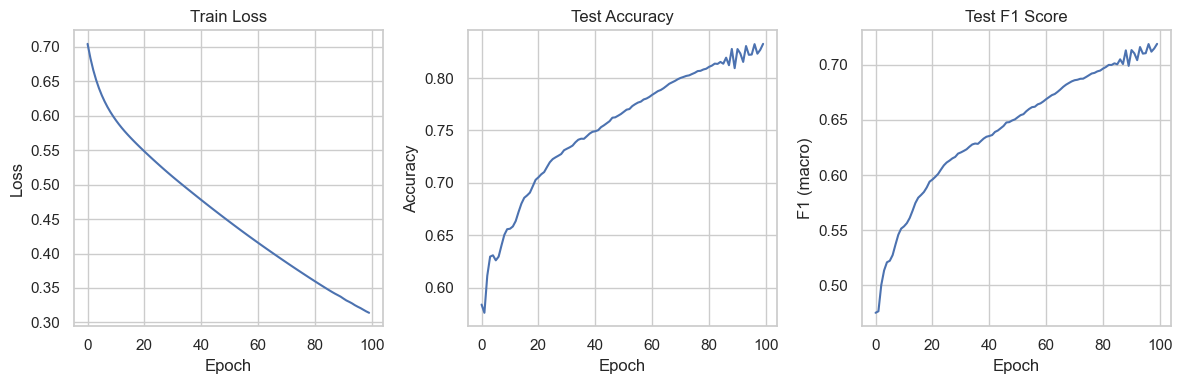

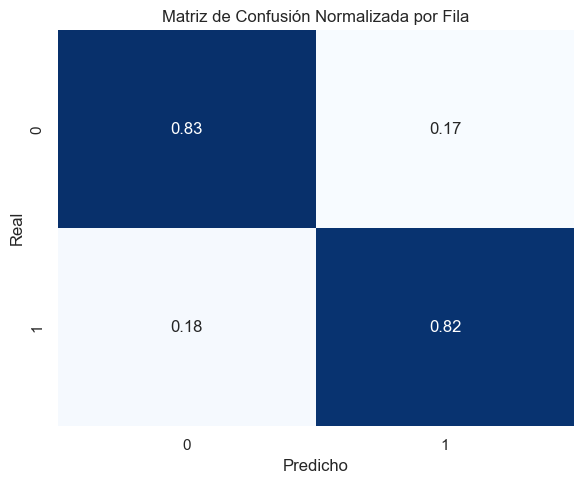

In [45]:
# 9. Listas para métricas
train_losses = []
test_accs    = []
test_f1s     = []

# 10. Bucle de entrenamiento
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(None, data.edge_index_dict)
    loss = criterion(out[train_mask], data["Product"].y[train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        acc = (pred[test_mask] == data["Product"].y[test_mask]).float().mean().item()
        f1  = f1_score(
            data["Product"].y[test_mask].cpu().numpy(),
            pred[test_mask].cpu().numpy(),
            average="macro"
        )
    train_losses.append(loss.item())
    test_accs.append(acc)
    test_f1s.append(f1)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Acc: {acc:.4f} | F1: {f1:.4f}")

# 11. Extraer embeddings post-entrenamiento
#with torch.no_grad():
#    emb_post = model.embeddings["Product"].weight.clone().cpu().numpy()
with torch.no_grad():
    logits = model(None, data.edge_index_dict)  # output final
    emb_postclass = logits.cpu().numpy()  # Esto es ya para clasificación    

# 12. Graficar métricas
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train Loss'); plt.grid(True)
plt.subplot(1, 3, 2)
plt.plot(test_accs, label='Test Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Test Accuracy'); plt.grid(True)
plt.subplot(1, 3, 3)
plt.plot(test_f1s, label='Test F1')
plt.xlabel('Epoch'); plt.ylabel('F1 (macro)'); plt.title('Test F1 Score'); plt.grid(True)
plt.tight_layout()
plt.show()

# 14. Matriz de confusión final
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model.eval()
with torch.no_grad():
    out = model(None, data.edge_index_dict)
    pred = out[test_mask].argmax(dim=1).cpu().numpy()
    true = data["Product"].y[test_mask].cpu().numpy()

# Obtener matriz de confusión
cm = confusion_matrix(true, pred)

# Normalizar por filas (eje 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Visualización
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión Normalizada por Fila')
plt.tight_layout()
plt.show()


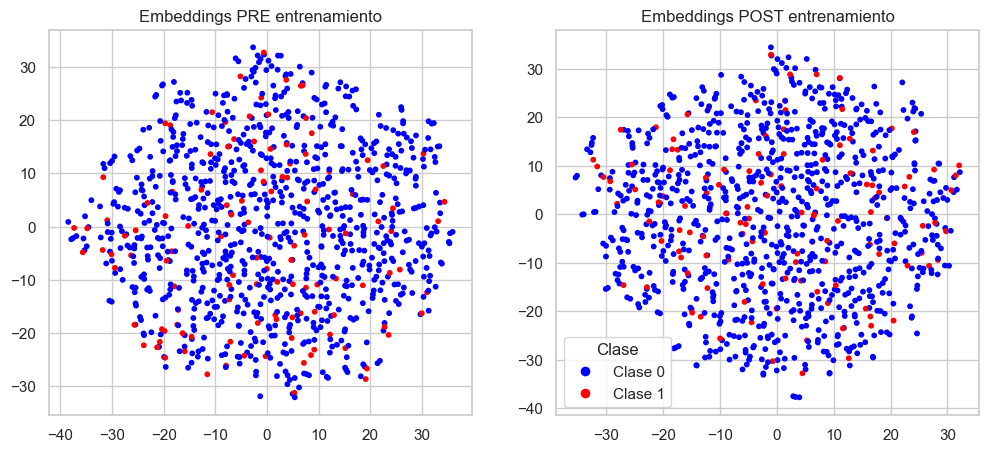

In [46]:
sample = np.random.choice(emb_pre.shape[0], size=1000, replace=False)
labels_sample = data["Product"].y.cpu().numpy()[sample]

tsne = TSNE(n_components=2, random_state=42)
emb_pre_2d = tsne.fit_transform(emb_pre[sample])
emb_post_2d = tsne.fit_transform(emb_post[sample])

colors = np.array(['blue', 'red']) if num_classes == 2 else plt.cm.tab10(np.arange(num_classes))
label_colors = colors[labels_sample]

plt.figure(figsize=(12,5))
for i, title in enumerate(["PRE entrenamiento", "POST entrenamiento"]):
    plt.subplot(1,2,i+1)
    emb_2d = emb_pre_2d if i == 0 else emb_post_2d
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=label_colors, s=10)
    plt.title(f"Embeddings {title}")
    if i == 1:
        from matplotlib.lines import Line2D
        if num_classes == 2:
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label='Clase 0', markerfacecolor='blue', markersize=8),
                Line2D([0], [0], marker='o', color='w', label='Clase 1', markerfacecolor='red', markersize=8)
            ]
        else:
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label=f'Clase {i}', markerfacecolor=plt.cm.tab10(i), markersize=8)
                for i in range(num_classes)
            ]
        plt.legend(handles=legend_elements, title="Clase")
plt.show()

No se aprecia una diferencia.

## Resumen resultados modelos a priori: 

Escenario A (con aristas hasChemical y features de químicos):
Mejor en clase 1 que A, lo que indica que la información relacional ayuda a identificar mejor la clase minoritaria o más difícil.

Escenario B (sin aristas hasChemical):
Mejor en clase 0 (Esperable al ser la clase mayoritaria y la más fácil de predecir solo con features del producto).

Escenario C (con aristas hasChemical pero features de químicos en cero):
Es el mejor en clase 1, pero el peor en clase 0. Esto sugiere que la estructura del grafo (saber qué productos comparten químicos, aunque no sepa qué químicos son) ayuda a la GNN a identificar patrones útiles para la clase 1, pero puede confundirla para la clase 0 si no tiene los features reales de los químicos.

## Comparacion con metodos de machine learning clasicos.

In [ ]:
import pandas as pd
import numpy as np

# Carga del CSV
df = pd.read_csv("cosmetics2.csv")

# --- Preprocesamiento de datos ---
# Etiqueta: ¿está descontinuado?
df['Discontinued'] = df['DiscontinuedDate'].notnull().astype(int)

# Me interesa mas la relación entre productos y químicos, asi que solo indico si un producto tiene o no un CSF y brand
# ¿Tiene CSF?
df['HasCSF'] = df['CSFId'].notnull().astype(int)

# ¿Tiene BrandName?
df['HasBrand'] = df['BrandName'].notnull().astype(int)

# --- One-hot encoding de químicos por producto ---
# QNos quedamos con las columnas relevantes para la relación producto-químico
df_prod_chem = df[['ProductName', 'ChemicalName']].drop_duplicates()

# Tabla de presencia de químicos
product_chem = pd.crosstab(df_prod_chem['ProductName'], df_prod_chem['ChemicalName'])

# Features agregados (sin fechas ni edad)
agg = df.groupby('ProductName').agg({
    'Discontinued': 'max',
    'HasCSF': 'max',
    'HasBrand': 'max',
    'CompanyId': 'first', # TOMO el primero, pero podría ser un problema si hay, pero mi interes esta en los quimicos
    'PrimaryCategoryId': 'first', # igual que CompanyId
    'SubCategoryId': 'first' # igual que CompanyId
}).reset_index()

# Se unen los features agregados con la matriz de químicos
agg = agg.merge(product_chem, left_on='ProductName', right_index=True)

# Opcional: codificar CompanyId, PrimaryCategoryId, SubCategoryId como categóricos.. lo hago mas adelante
# agg = pd.get_dummies(agg, columns=['CompanyId', 'PrimaryCategoryId', 'SubCategoryId'])

In [ ]:
# --- Entrenamiento de un modelo simple ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = agg.drop(['ProductName', 'Discontinued'], axis=1)
y = agg['Discontinued']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_estimators=50,
    max_depth=10,
    n_jobs=-1  # Usa todos los núcleos disponibles
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.61      0.74      8820
           1       0.23      0.82      0.36      1295

    accuracy                           0.63     10115
   macro avg       0.60      0.71      0.55     10115
weighted avg       0.86      0.63      0.69     10115



CV ROC‑AUC (5‑fold): 0.904 ± 0.007

Classification Report (test):
              precision    recall  f1-score   support

           0      0.959     0.868     0.911      8820
           1      0.454     0.750     0.566      1295

    accuracy                          0.853     10115
   macro avg      0.707     0.809     0.739     10115
weighted avg      0.895     0.853     0.867     10115

Test ROC‑AUC: 0.899


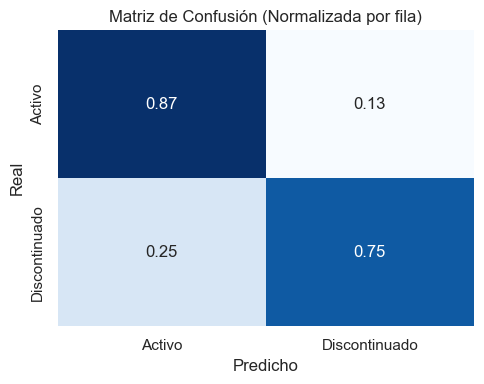

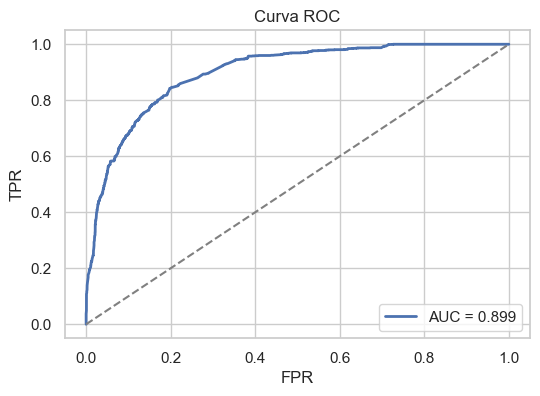

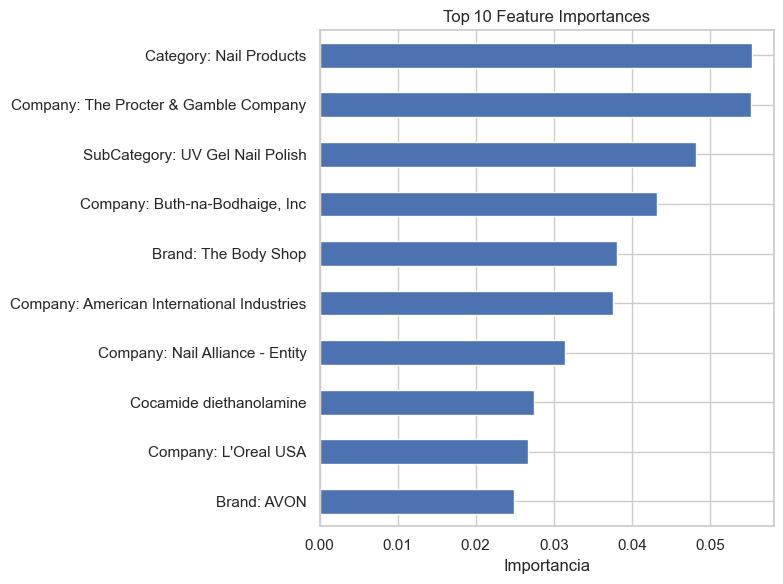

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score,
    confusion_matrix, roc_curve
)

# 1) Carga del CSV
df = pd.read_csv("cosmetics2.csv")

# 2) Etiqueta binaria: 1 si tiene DiscontinuedDate
df['Discontinued'] = df['DiscontinuedDate'].notnull().astype(int)

# 3) Features simples
df['HasCSF']   = df['CSFId'].notnull().astype(int)
df['HasBrand'] = df['BrandName'].notnull().astype(int)

# 4) Edad en días
df['InitialDateReported']    = pd.to_datetime(df['InitialDateReported'], errors='coerce')
df['MostRecentDateReported'] = pd.to_datetime(df['MostRecentDateReported'], errors='coerce')
df['AgeDays'] = (df['MostRecentDateReported'] - df['InitialDateReported']).dt.days.fillna(0).astype(int)

# 5) Crosstab Producto–Químico
df_prod_chem = df[['ProductName', 'ChemicalName']].dropna().drop_duplicates()
product_chem = pd.crosstab(df_prod_chem['ProductName'], df_prod_chem['ChemicalName'])

# 6) Agregar por producto y conservar nombres originales
agg = df.groupby('ProductName').agg({
    'Discontinued':       'max',
    'HasCSF':             'max',
    'HasBrand':           'max',
#    'AgeDays':            'first',
    'CompanyName':        'first',
    'PrimaryCategory':'first',
    'SubCategory':    'first',
    'BrandName':          'first',
}).reset_index()

# 6.1) Añadir prefijos a cada categoría nominal
agg['CompanyName']         = "Company: " + agg['CompanyName'].fillna("Unknown")
agg['PrimaryCategory'] = "Category: " + agg['PrimaryCategory'].fillna("Unknown")
agg['SubCategory']     = "SubCategory: " + agg['SubCategory'].fillna("Unknown")
agg['BrandName']           = "Brand: " + agg['BrandName'].fillna("Unknown")


# 7) One-hot encoding, ahora los nombres ya tienen prefijos
agg = pd.get_dummies(
    agg,
    columns=['CompanyName', 'PrimaryCategory', 'SubCategory', 'BrandName'],
    prefix='',    # no se necesita más prefijo
    prefix_sep='',
    dtype=int
)

# 8) Unir con matriz de químicos
data = agg.merge(
    product_chem,
    left_on='ProductName',
    right_index=True,
    how='left'
).fillna(0)

# 9) Preparar X, y
X = data.drop(['ProductName', 'Discontinued'], axis=1)
y = data['Discontinued']

# 10) Split estratificado 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.3,
    random_state=42
)

# 11) RandomForest con validación cruzada para ROC‑AUC
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(
    clf, X_train, y_train,
    cv=cv, scoring='roc_auc', n_jobs=-1
)
print(f"CV ROC‑AUC (5‑fold): {auc_scores.mean():.3f} ± {auc_scores.std():.3f}")

# Entrena sobre todo train
clf.fit(X_train, y_train)

# 12) Evaluación en test
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
print("\nClassification Report (test):")
print(classification_report(y_test, y_pred, digits=3))
print(f"Test ROC‑AUC: {roc_auc_score(y_test, y_proba):.3f}")

from sklearn.metrics import ConfusionMatrixDisplay

# 13) Matriz de confusión normalizada (por clase real)
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",        # muestra con 2 decimales
    cmap="Blues",
    cbar=False,
    xticklabels=["Activo", "Discontinuado"],
    yticklabels=["Activo", "Discontinuado"]
)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión (Normalizada por fila)")
plt.tight_layout()
plt.show()


# 14) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 15) Importancia de features (nombres incluidos)
importances = pd.Series(clf.feature_importances_, index=X.columns)
top20 = importances.nlargest(10)
plt.figure(figsize=(8,6))
top20.sort_values().plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()
